In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.models.spots import add_spots
from spice.plots import plot_3D
from spice.spectrum import simulate_observed_flux
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import TransformerPayne, Blackbody
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [2]:
b = Blackbody()

In [26]:
from spice.models.utils import lat_to_theta, lon_to_phi, velocity_to_period

m = IcosphereModel.construct(1000, 1., 1.,
                             b.to_parameters(),
                             b.parameter_names)

period_seconds = velocity_to_period(20., m.radius)
timestamps = jnp.linspace(0, period_seconds, 100)

# Convert inclination to LOS vector
mt = add_rotation(m, 20.)

SPOT_RADIUS = 30.

ms = add_spots(mt,
               spot_center_thetas=jnp.array([lat_to_theta(lat_deg) for lat_deg in [0]]),
               spot_center_phis=jnp.array([lon_to_phi(lon_deg) for lon_deg in [90]]),
               spot_radii=jnp.array([SPOT_RADIUS]),
               parameter_deltas=jnp.array([-1000]),
               parameter_indices=jnp.array([0]),
               smoothness=jnp.array([0.5]))


/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


In [27]:
mts = [evaluate_rotation(ms, t) for t in tqdm(timestamps)]

100%|██████████| 100/100 [00:00<00:00, 9201.26it/s]


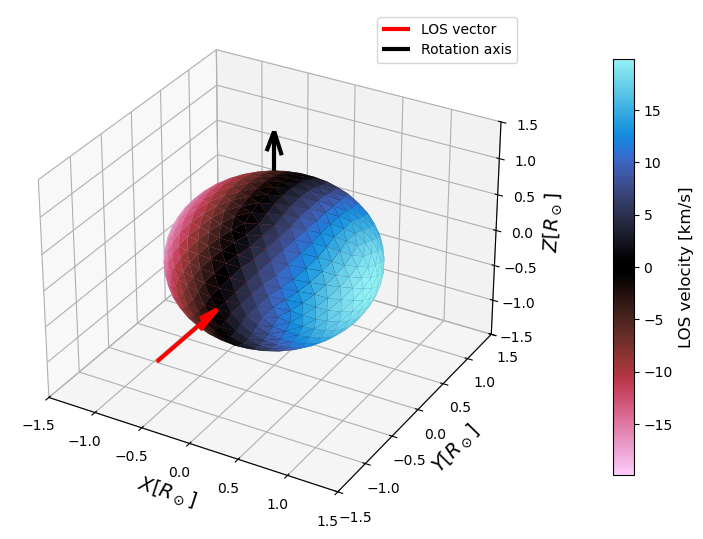

In [28]:
fig, _ = plot_3D(mts[0], 'los_velocities');

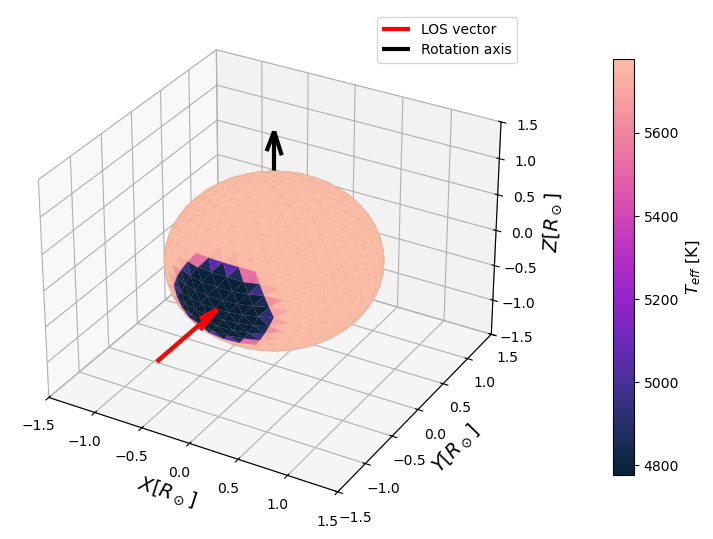

In [29]:
i = 50
fig, _ = plot_3D(mts[i], 0, property_label=r'$T_{eff}$ [K]');

In [34]:
vws = jnp.linspace(3000, 10000, 10000)
spec = []
for mt in tqdm(mts):
    spec.append(simulate_observed_flux(b.intensity, mt, jnp.log10(vws)))

100%|██████████| 100/100 [00:21<00:00,  4.61it/s]


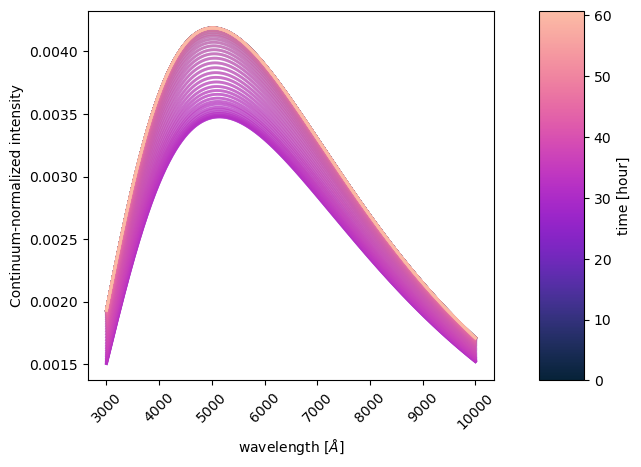

In [35]:
import matplotlib as mpl
import cmasher as cmr

fig, ax = plt.subplots(nrows=1, ncols=2, width_ratios=(9, 1))

n_lines = len(spec)
cmap = cmr.bubblegum

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))

from scipy.ndimage import gaussian_filter1d

for s, c in zip(spec, colors):
    # Apply Gaussian smoothing to the spectrum
    ax[0].plot(vws, s[:, 1], color=c, alpha=0.5, linewidth=2)
    
ax[0].set_xlabel(r'wavelength [$\AA$]')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel('Continuum-normalized intensity');
norm = mpl.colors.Normalize(vmin=timestamps[0]/3600, vmax=timestamps[-1]/3600)
cbar = ax[1].figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='cmr.bubblegum'),
            cax=ax[1], pad=.05);
cbar.set_label('time [hour]');

In [19]:
sp = jnp.array(t.to_parameters())
def intensity_for__item(vw: float, fe: float):
    p = b.intensity(jnp.log10(jnp.array([vw])), 1.0, sp.at[27].set(fe))
    return p[0, 0]

def intensity_for_fe(vw: float, fe: float):
    p = t.intensity(jnp.log10(jnp.array([vw])), 1.0, sp.at[27].set(fe))
    return p[:, 0]/p[:, 1]

In [20]:
i = intensity_for_fe(vws[0], 1.0)
i

Array([0.9806021], dtype=float32)

In [21]:
import jax
spectrum_for_fe = jax.vmap(intensity_for_fe, in_axes=(0, None))

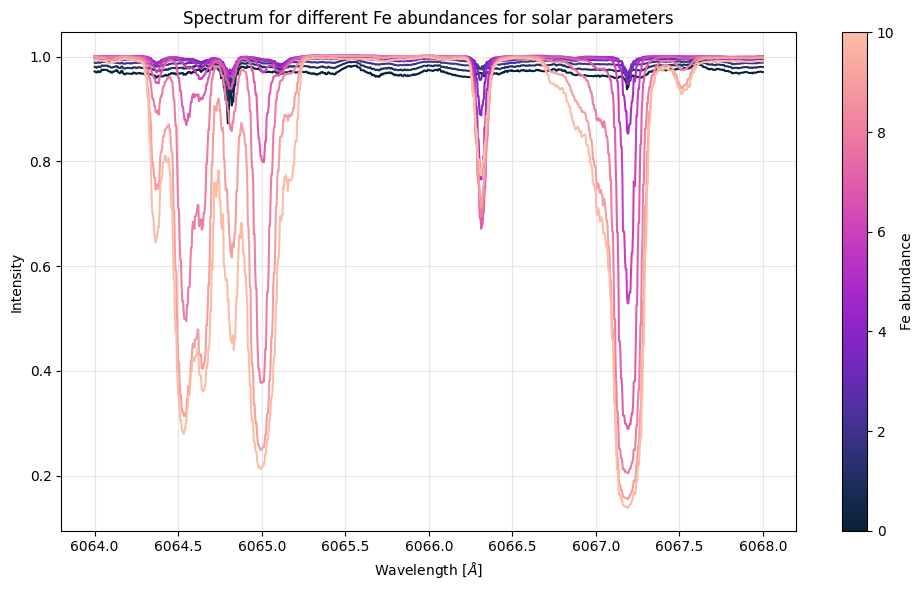

In [33]:
# Define a range of Fe values to plot
fe_values = [0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]

# Create a figure with a main plot and space for a colorbar
fig, ax = plt.subplots(figsize=(10, 6))

# Get colors from the bubblegum colormap
cmap = cmr.bubblegum
colors = cmap(np.linspace(0, 1, len(fe_values)))

# Plot spectrum for each Fe value with assigned colors
for fe, color in zip(fe_values, colors):
    # Get the spectrum for this Fe value
    spectrum = spectrum_for_fe(vws, fe)
    # Plot with assigned color but no label
    ax.plot(vws, spectrum, color=color)

# Add labels
ax.set_xlabel(r'Wavelength [$\AA$]')
ax.set_ylabel('Intensity')
ax.set_title('Spectrum for different Fe abundances for solar parameters')
ax.grid(True, alpha=0.3)

# Create a colorbar
norm = mpl.colors.Normalize(vmin=min(fe_values), vmax=max(fe_values))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Fe abundance')

plt.tight_layout()
plt.show()

In [29]:
import jax
grad_flux = jax.grad(intensity_for_fe_item, argnums=1)

In [30]:
grad_flux_spectrum = jax.vmap(lambda vw, fe: jnp.array([grad_flux(vw, fe)]), in_axes=(0, None))

In [31]:
# The error occurs because we're trying to use .item() with JAX tracers
# Let's modify our approach to avoid the ConcretizationTypeError

# First, let's redefine the intensity_for_fe_item function to not use .item()
def intensity_for_fe_item_fixed(vw: float, fe: float):
    p = t.intensity(jnp.log10(jnp.array([vw])), 1.0, sp.at[27].set(fe))
    return (p[:, 0]/p[:, 1])[0]  # Return the array instead of using .item()

# Now redefine the gradient function
grad_flux_fixed = jax.grad(intensity_for_fe_item_fixed, argnums=1)

# And redefine the vectorized version
grad_flux_spectrum_fixed = jax.vmap(lambda vw, fe: grad_flux_fixed(vw, fe), in_axes=(0, None))

# Test the fixed version
test_result = grad_flux_spectrum_fixed(vws, 1.0)
print(f"Shape of gradient result: {test_result.shape}")

Shape of gradient result: (1000,)


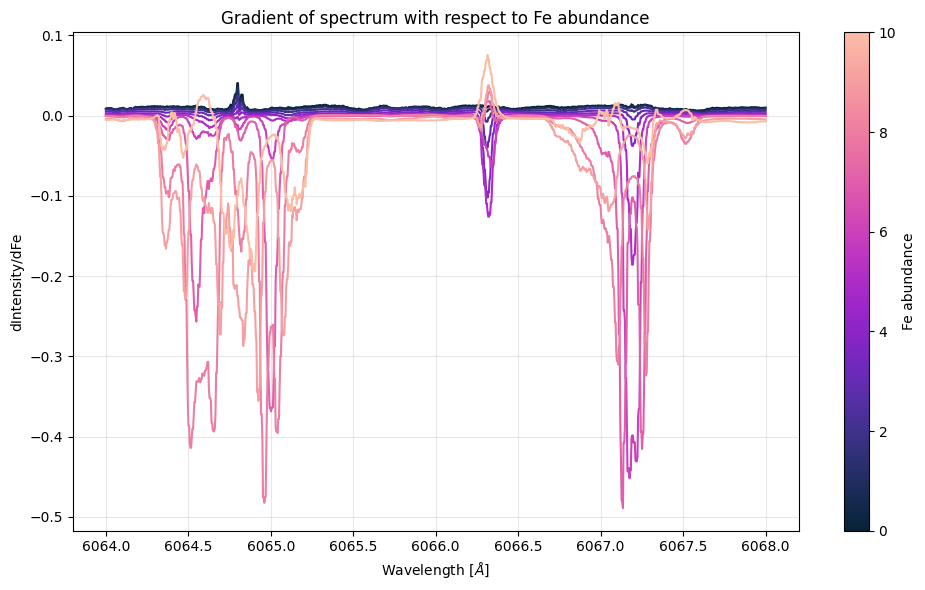

In [34]:
# Define a range of Fe values to plot
fe_values = [0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a colormap
cmap = cmr.bubblegum

# Plot gradient for each Fe value
for i, fe in enumerate(fe_values):
    # Get the gradient for this Fe value
    gradient = grad_flux_spectrum_fixed(vws, fe)
    # Plot with a color from the colormap based on fe value
    color = cmap(i / (len(fe_values) - 1))
    ax.plot(vws, gradient, color=color)

# Add labels
ax.set_xlabel(r'Wavelength [$\AA$]')
ax.set_ylabel('dIntensity/dFe')
ax.set_title('Gradient of spectrum with respect to Fe abundance')
ax.grid(True, alpha=0.3)

# Create a colorbar
norm = mpl.colors.Normalize(vmin=min(fe_values), vmax=max(fe_values))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Fe abundance')

plt.tight_layout()
plt.show()


In [9]:
# Save the meshes as a pickle file
import pickle

# Assuming 'mts' contains the meshes we want to save
# Let's create a descriptive filename
meshes_filename = 'fe_meshes.pkl'

# Save the meshes using pickle
with open(meshes_filename, 'wb') as f:
    pickle.dump(mts, f)

print(f"Meshes saved to {meshes_filename}")


Meshes saved to fe_meshes.pkl


In [16]:
spec = np.array(spec)
spec.shape

(100, 1000, 2)

In [18]:
from spice.plots.plot_mesh import animate_mesh_and_spectra


animate_mesh_and_spectra(mts, spec[:, :, 0], vws, filename='fe_animation_spectrum.gif',
                         property=27, property_label='Fe abundance')

'fe_animation_spectrum.gif'

In [8]:

np.save('fe_specs.npy', spec)

In [41]:

def intensity_for_fe_item(vw: float, parameters: jnp.ndarray):
    _mt = mts[0]
    _mt = _mt._replace(parameters=parameters)
    p = simulate_observed_flux(t.intensity, _mt, jnp.log10(jnp.atleast_1d(vw)), chunk_size=2048)
    return p[0, 0]/p[0, 1]

In [42]:
intensity_for_fe_item(vws[0], mts[0].parameters)

Array(0.842815, dtype=float32)

In [43]:
grad = jax.grad(intensity_for_fe_item, argnums=1)

In [ ]:
grad(vws[0], mts[0].parameters)

Array(True, dtype=bool)

In [10]:
sm_ts = jnp.linspace(0, period_seconds, 5)
sm_mts = [evaluate_rotation(ms, t) for t in sm_ts]

In [11]:
LINE_NAMES = [
    'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Fe I', 'Cr II', 'Fe II', 'Fe II'
]

LINE_CENTERS = [
    5005.7122, 5006.1186, 5242.4907, 5263.3062, 5367.4659, 5383.3685, 5397.1279, 6146.1788, 6147.7341, 6149.2459
]

In [12]:
line_vws = [np.linspace(LC-1, LC+1, 200) for LC in LINE_CENTERS]
line_specs = []

for i in tqdm(range(len(LINE_CENTERS))):
    line_specs.append([simulate_observed_flux(t.intensity, mt, jnp.log10(line_vws[i]), chunk_size=2048) for mt in sm_mts])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:22<00:00, 20.24s/it]


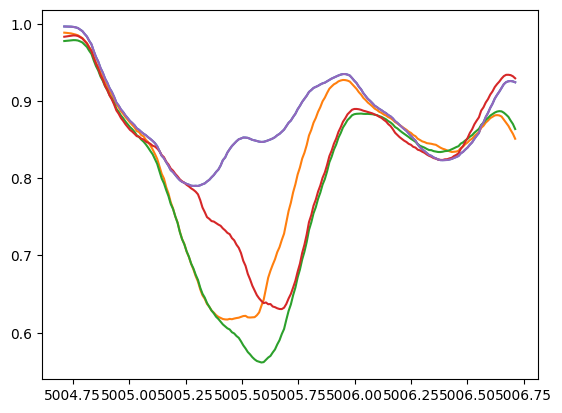

In [13]:
for i in range(5):
    plt.plot(line_vws[0], line_specs[0][i][:, 0]/line_specs[0][i][:, 1])

<>:12: SyntaxWarning: invalid escape sequence '\A'
<>:12: SyntaxWarning: invalid escape sequence '\A'
/jobfs/140217213.gadi-pbs/ipykernel_984716/3614217645.py:12: SyntaxWarning: invalid escape sequence '\A'
  axs[i, 0].text(-0.6, 0.45, f'{LINE_CENTERS[i]} $\AA$', horizontalalignment='center', verticalalignment='center', transform=axs[i, 0].transAxes)


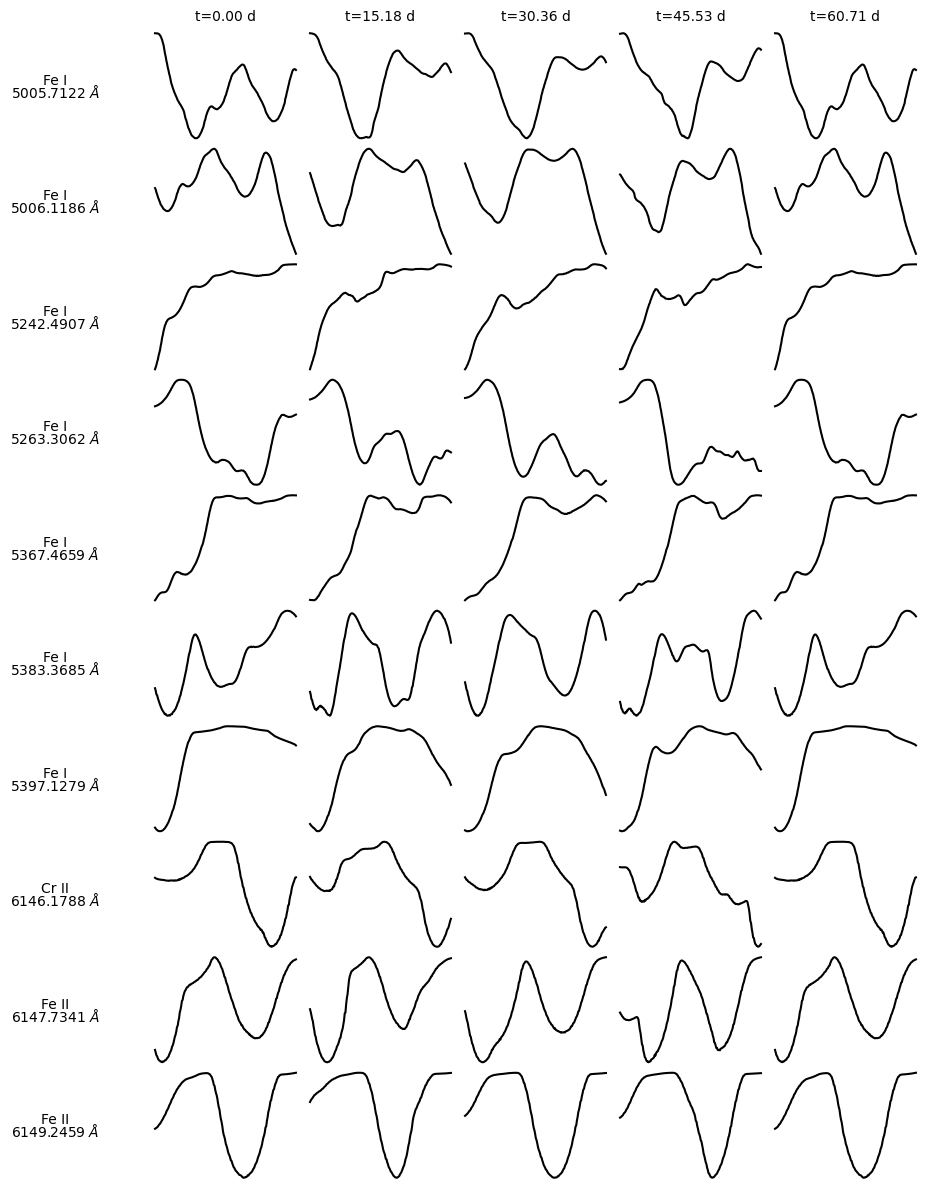

In [15]:
fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(10, 15))

# Iterate over each subplot and remove the axes
for i in range(len(LINE_CENTERS)):
    for j in range(5):
        axs[i, j].axis('off')
        axs[i, j].plot(line_specs[i][j][:, 0]/line_specs[i][j][:, 1], color='black')

# Add annotations before each row
for i in range(len(LINE_CENTERS)):
    axs[i, 0].text(-0.6, 0.55, f'{LINE_NAMES[i]}', horizontalalignment='center', verticalalignment='center', transform=axs[i, 0].transAxes)
    axs[i, 0].text(-0.6, 0.45, f'{LINE_CENTERS[i]} $\AA$', horizontalalignment='center', verticalalignment='center', transform=axs[i, 0].transAxes)

# Add annotations above each column
for j in range(5):
    axs[0, j].text(0.5, 1.1, f't={sm_ts[j]/3600:.2f} d', horizontalalignment='center', verticalalignment='center', transform=axs[0, j].transAxes)

# Adjust layout
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [28]:
line_specs = np.array(line_specs)
line_specs.shape

(10, 5, 200, 2)

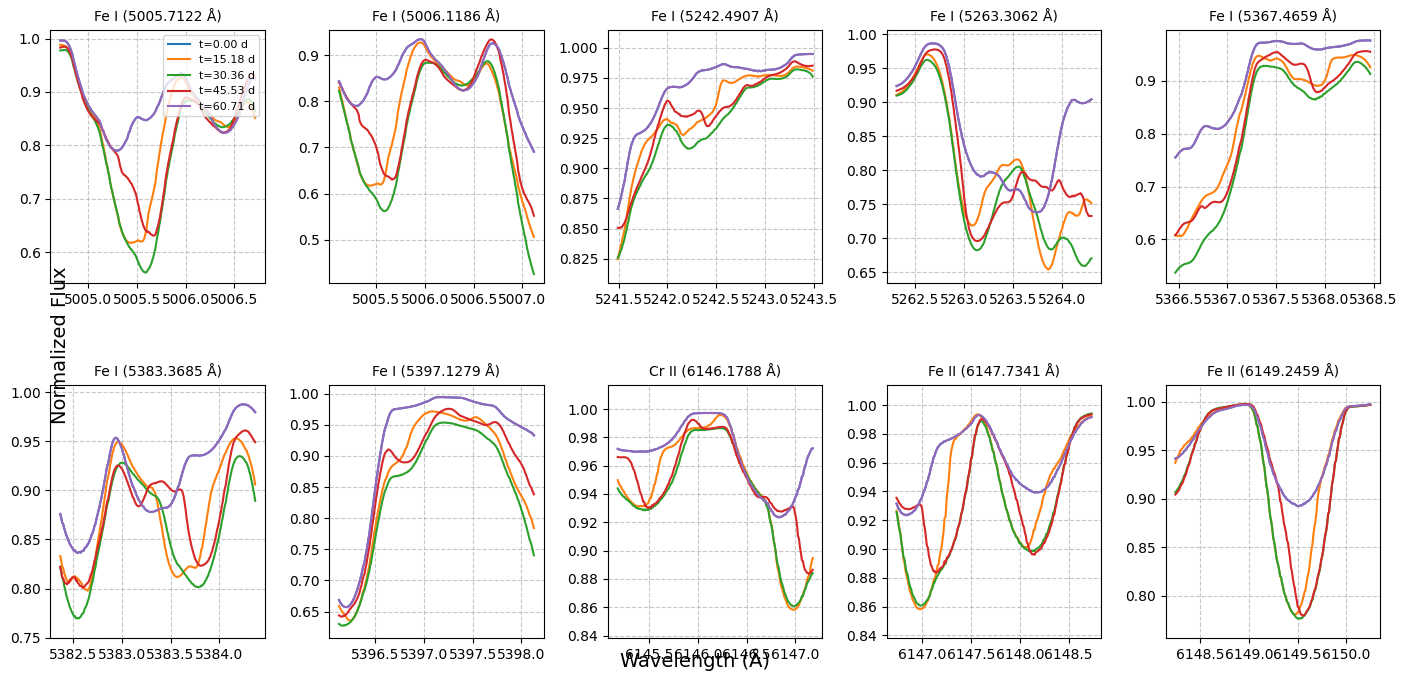

In [34]:
# Create a 2D plot with subplots arranged in a grid
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(14, 7))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Plot each line in its own subplot
for i in range(len(LINE_CENTERS)):
    ax_idx = i
    if ax_idx >= len(axs):
        break
        
    for j in range(5):
        # Calculate the normalized flux
        normalized_flux = line_specs[i][j][:, 0]/line_specs[i][j][:, 1]
        
        # Plot with different line styles for different times
        axs[ax_idx].plot(line_vws[i], normalized_flux, 
                       label=f't={sm_ts[j]/3600:.2f} d', 
                       linewidth=1.5)
    
    # Add line information as title
    axs[ax_idx].set_title(f'{LINE_NAMES[i]} ({LINE_CENTERS[i]} Å)', fontsize=10)
    
    # Add grid for better readability
    axs[ax_idx].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend to the first subplot only
    if i == 0:
        axs[ax_idx].legend(loc='upper right', fontsize=8)
    
    # Set y-limits with a bit of padding
    y_min = np.min([np.min(line_specs[i][j][:, 0]/line_specs[i][j][:, 1]) for j in range(5)]) - 0.02
    y_max = np.max([np.max(line_specs[i][j][:, 0]/line_specs[i][j][:, 1]) for j in range(5)]) + 0.02
    axs[ax_idx].set_ylim(y_min, y_max)

# Add common x and y labels
fig.text(0.5, 0.04, 'Wavelength (Å)', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Normalized Flux', va='center', rotation='vertical', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()


In [30]:
fig.savefig('example_lines.png')